## Homework 4

### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

### Class Definitions (used for problems)

In [1]:
class Gwas_data:

    def __init__(self, n, s):
        self.n = n
        self.s = s
    
    def make_genotype_matrix(self):
        '''Problem 1a'''
        G = np.zeros((self.n, self.s))
        snp_ps = []
        for snp in range(self.s):
            p = np.random.uniform()
            snp_ps.append(p)
            s_array = np.array(np.random.binomial(2, p, size = self.n))
            G[:, snp] = s_array
        self.snp_ps = snp_ps

        # scale genotypes
        standardized_G = StandardScaler().fit_transform(G)
        self.G = standardized_G
    
    def make_genotype_matrix_discrete_pops(self, fst):
        '''Problem 3a'''
        # n = 1000 for each population
        G = np.zeros((self.n, self.s))
        for snp in range(self.s):
            anc_p = np.random.uniform()
            pop1_p, pop2_p = np.random.beta(anc_p*(1-fst)/fst, (1-anc_p)*(1-fst)/fst, size=2)
            s_array = np.array(list(np.random.binomial(2, pop1_p, size=int(self.n/2))) + list(np.random.binomial(2, pop2_p, size=int(self.n/2))))
            G[:, snp] = s_array
        
        standardized_G = StandardScaler().fit_transform(G)
        self.G = standardized_G

    def make_genotype_matrix_test(self, train_gwas_data):
        '''Problem 2a'''
        G = np.zeros((self.n, self.s))
        snp_ps = train_gwas_data.snp_ps
        for snp in range(self.s):
            s_array = np.array(np.random.binomial(2, snp_ps[snp], size = self.n))
            G[:, snp] = s_array
        self.snp_ps = snp_ps

        # scale genotypes
        standardized_G = StandardScaler().fit_transform(G)
        self.G = standardized_G
    
    def simulate_phenotypes(self, h2, c=0):
        '''Problem 1b'''
        ve = 1 - h2
        va = h2

        causal_snps = np.random.choice(range(0, self.s), size=100, replace=False)
        effect_sizes = list(np.random.normal(loc=0, scale = np.sqrt(va/100), size=100))

        causal_snp_effect = dict(zip(range(0, self.s), [0]*self.s))
        for k in list(causal_snp_effect.keys()):
            if k in causal_snps:
                causal_snp_effect[k] = effect_sizes[0]
                del effect_sizes[0]
        self.causal_snp_effect = causal_snp_effect

        phenotypes = []
        phenotypes_causal = []
        phenotypes_noise = []
        for i, row in enumerate(self.G):
            phenotype_causal = np.sum(np.array(row) * np.array(list(causal_snp_effect.values())))
            phenotype_noise = np.random.normal(loc=0, scale=np.sqrt(ve))
            phenotype = phenotype_causal + phenotype_noise

            if c != 0 and i < self.n/2:
                phenotype = phenotype + c

            phenotypes.append(phenotype)
            phenotypes_causal.append(phenotype_causal)
            phenotypes_noise.append(phenotype_noise)

        standardized_phen = StandardScaler().fit_transform(np.array(phenotypes).reshape(-1, 1))
        self.phenotypes = standardized_phen

        return phenotypes_causal, phenotypes_noise, phenotypes
    
    def simulate_phenotypes_test(self, h2, train_gwas_data, c=0):
        '''Problem 2a'''
        self.causal_snp_effect = train_gwas_data.causal_snp_effect
        ve = 1 - h2
        va = h2

        phenotypes = []
        phenotypes_causal = []
        phenotypes_noise = []
        for i, row in enumerate(self.G):
            phenotype_causal = np.sum(np.array(row) * np.array(list(self.causal_snp_effect.values())))
            phenotype_noise = np.random.normal(loc=0, scale=np.sqrt(ve))
            phenotype = phenotype_causal + phenotype_noise

            if c != 0 and i < self.n/2:
                phenotype = phenotype + c

            phenotypes.append(phenotype)
            phenotypes_causal.append(phenotype_causal)
            phenotypes_noise.append(phenotype_noise)

        standardized_phen = StandardScaler().fit_transform(np.array(phenotypes).reshape(-1, 1))
        self.phenotypes = standardized_phen

        return phenotypes_causal, phenotypes_noise, phenotypes

    def perform_gwas_try2(self):

        betas = np.zeros(self.s)
        beta_p_values = np.zeros(self.s)

        for i in range(self.s):
            X = self.G[:, i]
            X = sm.add_constant(X)
            model = sm.OLS(self.phenotypes, X)
            results = model.fit()
            betas[i] = results.params[1]
            beta_p_values[i] = results.pvalues[1]
        
        self.betas = betas.flatten()
        self.beta_p_values = beta_p_values
        return betas, beta_p_values

    def perform_gwas(self):
        '''Problem 1c'''

        betas = (1/self.n) * self.G.T @ self.phenotypes

        y_hat = self.G @ betas
        residuals = self.phenotypes - y_hat
        sigma_e_squared = (1 / self.n) * np.sum(residuals ** 2, axis=0)
        G_sq = np.sum(self.G ** 2, axis=0)
        se_betas = np.sqrt(sigma_e_squared / G_sq)
        z_scores = betas.flatten() / se_betas
        p_values = 2 * norm.sf(np.abs(z_scores))

        # for snp in range(0, self.s):
        #     print(str(snp) + '/' + str(self.s))
        #     G_j = self.G[:, snp]
        #     beta_hat = (1/self.n)*G_j.T @ self.phenotypes
        #     betas.append(beta_hat)

        #     y_hat = G_j * beta_hat
        #     residuals = self.phenotypes - y_hat
        #     sigma_e_squared = (1 / self.n) * np.sum(residuals**2)
        #     se_beta = np.sqrt(sigma_e_squared / (G_j.T @ G_j))
        #     z = beta_hat / se_beta
        #     p = 2 * norm.sf(np.abs(z))
        #     beta_p_values.append(p)
        
        self.betas = betas.flatten()
        self.beta_p_values = p_values
        return self.betas, self.beta_p_values

    def make_qq_plot(self, title='QQ Plot'):
        p_values = np.asarray(self.beta_p_values)
        p_values = p_values[~np.isnan(p_values)]  # Remove NaNs if any
        p_values = np.clip(p_values, 1e-300, 1)   # Avoid -inf in log10

        expected = -np.log10(np.linspace(1 / len(p_values), 1, len(p_values)))
        observed = -np.log10(np.sort(p_values))

        plt.figure(figsize=(6, 6))
        plt.plot(expected, observed, 'o', markersize=3, label='Observed')
        plt.plot(expected, expected, 'r--', label='Expected under null')
        plt.xlabel('Expected -log10(p)')
        plt.ylabel('Observed -log10(p)')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def calculate_lambda_gc(self):
        '''Problem 1d'''
        chisq = chi2.isf(1-np.array(self.beta_p_values), 1)
        lambda_gc = np.nanmedian(chisq) / chi2.isf(0.5, 1)
        return lambda_gc
    
    def build_prs(self, train_gwas_data, threshold):
        '''Problem 2c'''
        #### this works but is very slow (same as below, just not vectorized)
        # sig_index_betas = [i for i in range(0, len(train_gwas_data.betas)) if train_gwas_data.beta_p_values[i] > threshold]
        # prs_list = []
        # for n in range(0, self.n):
        #     prs = 0
        #     for i in sig_index_betas:
        #         prs += self.G[n, i] * train_gwas_data.betas[i]
        #     prs_list.append(prs)

        snp_mask = train_gwas_data.beta_p_values < threshold
        selected_betas = train_gwas_data.betas[snp_mask]
        selected_genotypes = self.G[:, snp_mask]

        prs = np.dot(selected_genotypes, selected_betas)
        prs = StandardScaler().fit_transform(prs.reshape(-1, 1))

        self.prs = prs
        r = np.corrcoef(self.phenotypes.flatten(), self.prs.flatten())[0, 1]
        r_sq = r*r
        r2_score_sklearn = r2_score(self.phenotypes.flatten(), self.prs.flatten())
        return prs, r, r_sq, r2_score_sklearn
    
    def crossval_optimize_prs(self, pval_thresholds):
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        avg_r2s = []

        for thresh in pval_thresholds:
            sig_mask = self.beta_p_values < thresh
            if not np.any(sig_mask):
                avg_r2s.append(0)
                continue

            G_sig = self.G[:, sig_mask]
            beta_sig = self.betas[sig_mask]
            
            r2_scores = []

            for train_idx, val_idx in kf.split(G_sig):
                G_val = G_sig[val_idx]
                y_val = self.phenotypes[val_idx]
                prs_val = G_val @ beta_sig
                y_val_c = y_val - np.mean(y_val)
                prs_val_c = prs_val - np.mean(prs_val)
                # r = np.corrcoef(y_val_c.flatten(), prs_val_c)[0, 1]
                # r2 = r*r
                r2 = r2_score(y_val_c, prs_val_c)
                r2_scores.append(r2)
            avg_r2s.append(np.mean(r2_scores))

        best_idx = np.argmax(avg_r2s)
        best_thresh = pval_thresholds[best_idx]

        return best_thresh, avg_r2s
    
    def perform_gwas_with_pc1(self):

        X = StandardScaler().fit_transform(self.G)
        pca = PCA(n_components=5)
        pcs = pca.fit_transform(X)   
        pc1 = pcs[:, 0]

        betas = np.zeros(self.s)
        beta_p_values = np.zeros(self.s)

        for i in range(self.s):
            X = self.G[:, i]
            X_model = np.column_stack((X, pc1))
            X_model = sm.add_constant(X_model)
            model = sm.OLS(self.phenotypes, X_model).fit()
            betas[i] = model.params[1]
            beta_p_values[i] = model.pvalues[1]
        
        self.betas = betas.flatten()
        self.beta_p_values = beta_p_values
        return betas, beta_p_values





### Problem 1

In [107]:
# Problem 1a

n = 2000
s = 10000

gwas_1 = Gwas_data(n, s)
gwas_1.make_genotype_matrix()

In [108]:
# Problem 1b

h2 = 0.3
phen_causal, phen_noise, phen = gwas_1.simulate_phenotypes(h2)

print('The experimental heritability is ' + str(np.var(phen_causal) / np.var(phen)))

The experimental heritability is 0.3317919158424573


In [109]:
# Problem 1c

betas, beta_p_values = gwas_1.perform_gwas_try2()

Text(0, 0.5, 'Frequency')

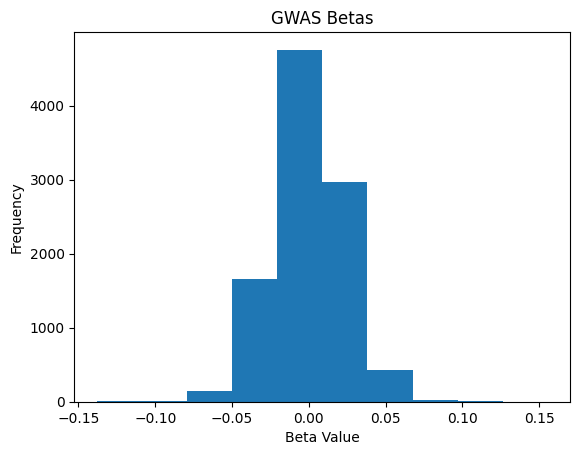

In [110]:
plt.hist(betas)
plt.title('GWAS Betas')
plt.xlabel('Beta Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

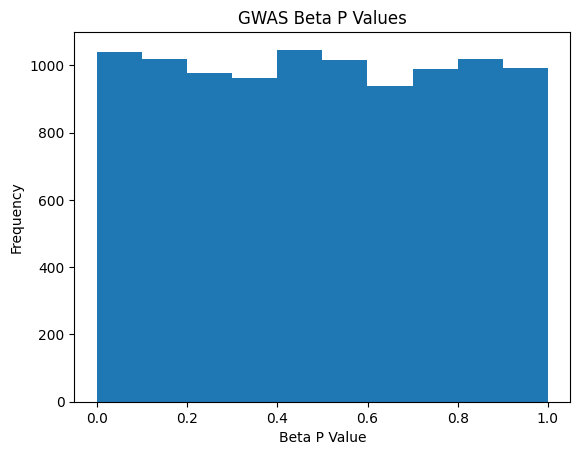

In [111]:
plt.hist(beta_p_values)
plt.title('GWAS Beta P Values')
plt.xlabel('Beta P Value')
plt.ylabel('Frequency')

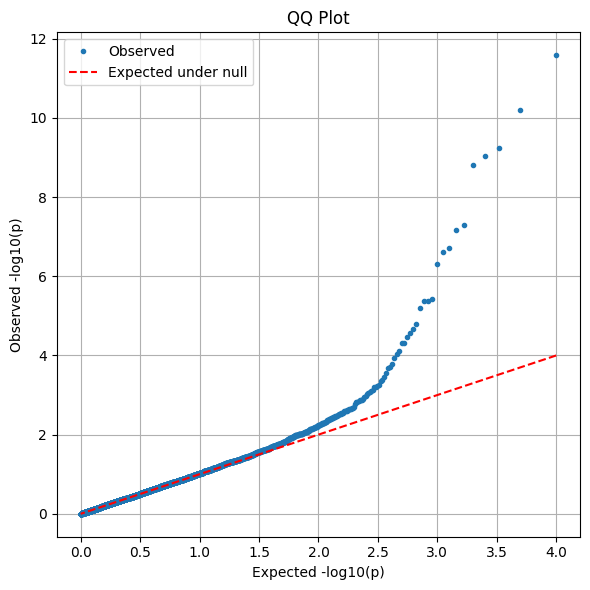

In [112]:
# Problem 1d

gwas_1.make_qq_plot()

In [113]:
lambda_gc = gwas_1.calculate_lambda_gc()
print('Lambda GC is ' + str(lambda_gc))

Lambda GC is 0.9792368753710233


### Problem 2

In [4]:
# Problem 2a

n = 2000
s = 10000

gwas_2_train = Gwas_data(int(0.8*n), s)
gwas_2_train.make_genotype_matrix()

gwas_2_test = Gwas_data(int(0.2*n), s)
gwas_2_test.make_genotype_matrix_test(train_gwas_data=gwas_2_train)

h2 = 0.3
phen_causal_train, phen_noise_train, phen_train = gwas_2_train.simulate_phenotypes(h2)
phen_causal_test, phen_noise_test, phen_test = gwas_2_test.simulate_phenotypes_test(h2, gwas_2_train)

In [5]:
# Problem 2b

betas, beta_p_values = gwas_2_train.perform_gwas_try2()

In [9]:
# Problem 2c

prs, r, r_sq, r2_score_sklearn = gwas_2_test.build_prs(gwas_2_train, 0.05)
print(r) # close to h2
print(r_sq)

0.2590569591793338
0.06711050809924302


In [126]:
# correlation between beta hats and true betas
np.corrcoef(gwas_2_train.betas, list(gwas_2_train.causal_snp_effect.values()))

array([[1.        , 0.23367384],
       [0.23367384, 1.        ]])

In [127]:
# correlation between test phenotypes and genotypes*true betas
causal_effects = np.array(list(gwas_2_train.causal_snp_effect.values()))
result = gwas_2_test.G @ causal_effects
r = np.corrcoef(gwas_2_test.phenotypes.flatten(), result)
r

array([[1.        , 0.58945569],
       [0.58945569, 1.        ]])

In [7]:
# Problem 2d

pval_thresholds = [5e-8, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.5, 1.0]

best_threshold, avg_r2 = gwas_2_train.crossval_optimize_prs(pval_thresholds)
print(best_threshold)
print(avg_r2[2]) # for best threshold

0.001
0.2596633027697858


In [11]:
prs, r, r_sq, r2_score_sklearn = gwas_2_test.build_prs(gwas_2_train, best_threshold)
print(r) # close to h2
print(r_sq)

0.3870866449778896
0.14983607072023872


### Problem 3

In [ ]:
# Problem 3a

n = 2000
s = 10000
gwas_3 = Gwas_data(n, s)
gwas_3.make_genotype_matrix_discrete_pops(fst=0.03)

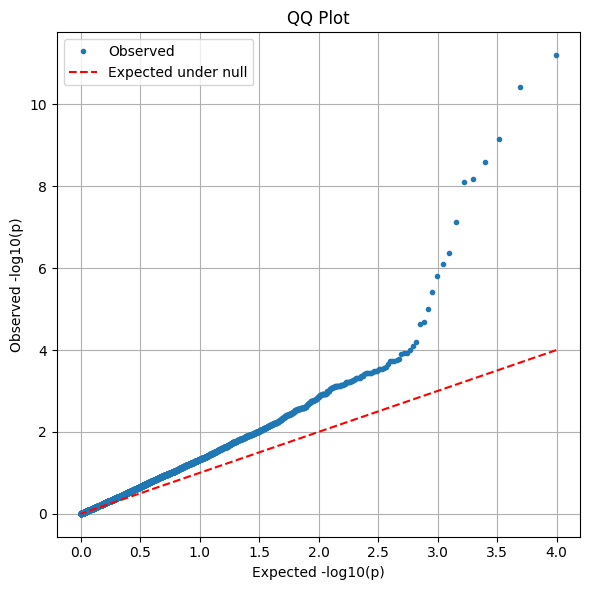

In [ ]:
# Problem 3b

h2 = 0.3
phen_causal, phen_noise, phen = gwas_3.simulate_phenotypes(h2)
betas, beta_p_values = gwas_3.perform_gwas_try2()
gwas_3.make_qq_plot()

In this plot, there are two discrete populations, but they are still related ancestrally, so the QQ plot isn't very different from problem 1.

In [ ]:
# Problem 3c

n = 2000
s = 10000
gwas_4 = Gwas_data(n, s)
gwas_4.make_genotype_matrix_discrete_pops(fst=0.03)
h2 = 0.3
phen_causal, phen_noise, phen = gwas_4.simulate_phenotypes(h2, c=1)

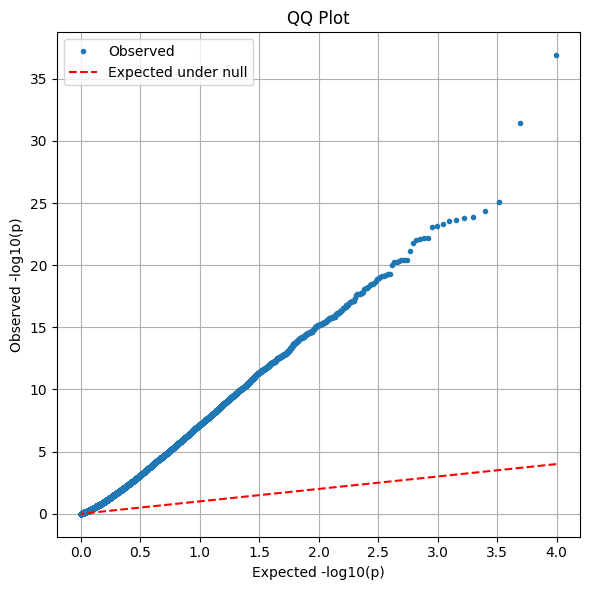

In [ ]:
# Problem 3d

betas, beta_p_values = gwas_4.perform_gwas_try2()
gwas_4.make_qq_plot()

In this plot, the two populations are very obviously different from one another because of the constant added to one population. Therefore the QQ plot shows that the observed P values are definitely not observable under the null assumption.

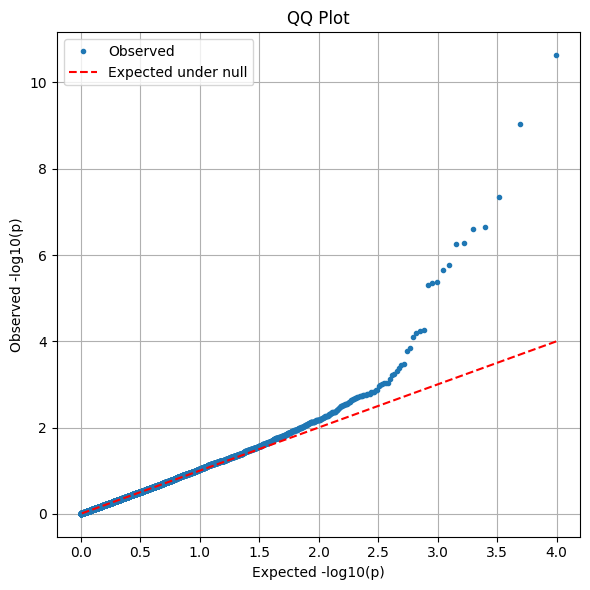

In [ ]:
# Problem 3f

n = 2000
s = 10000
gwas_5 = Gwas_data(n, s)
gwas_5.make_genotype_matrix_discrete_pops(fst=0.03)
h2 = 0.3
phen_causal, phen_noise, phen = gwas_5.simulate_phenotypes(h2, c=1)

betas, beta_p_values = gwas_5.perform_gwas_with_pc1()
gwas_5.make_qq_plot()

Using dimensionality reduction reduced the number of significant SNPs by a large proportion. These SNPs are much more likely to actually be significant.